In [11]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import Siren
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Clustering, Threshold
from deepymod_torch.training import train
from deepymod_torch.training.sparsity_scheduler import Periodic

from phimal_utilities.data import Dataset
from phimal_utilities.data.kdv import DoubleSoliton
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
# Making data
# Making data
v = 0.1
A = 1.0
x = np.linspace(-5, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=[5.0, 2.0], x0=[-3.0, -1.0])
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.10, normalize=True, random=True)

In [4]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=5000, periodicity=5) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [5]:

train(model, X_train, y_train, optimizer, sparsity_scheduler, write_iterations=25, max_iterations=1000, delta=0.0) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1000    100.00%               0s   3.94e-03   3.90e-03   3.06e-05   2.76e+00 

# Inside grid

In [42]:
X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=True, random=False)

In [43]:
p_predicted = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)

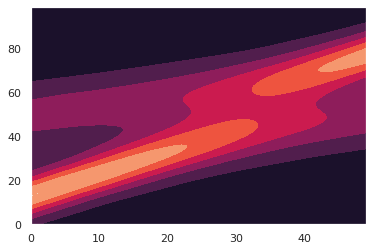

In [44]:
plt.contourf(p_predicted)

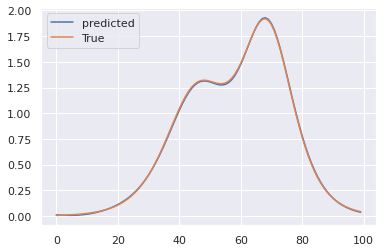

In [48]:
plt.plot(p_predicted[:, 40], label='predicted')
plt.plot(y_full.cpu().detach().numpy().reshape(x_grid.shape)[:, 40], label='True')
plt.legend()

# Extrapolating

In [166]:
x_predict = np.linspace(-5, 5, 100)
t_predict = np.linspace(1.0, 1.5, 50)

x_grid, t_grid = np.meshgrid(x_predict, t_predict, indexing='ij')

In [167]:
X_predict, y_predict = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=True, random=False)

In [168]:
X_predict[:5, :]

tensor([[ 1.0000, -1.0000],
        [ 1.0204, -1.0000],
        [ 1.0408, -1.0000],
        [ 1.0612, -1.0000],
        [ 1.0816, -1.0000]])

In [173]:
p_predicted = model(X_predict)[0].cpu().detach().numpy().reshape(x_grid.shape)

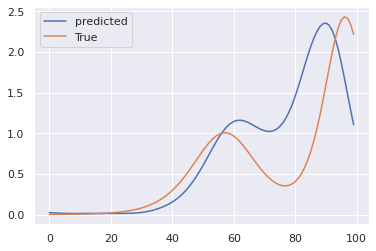

In [176]:
frame = 40
plt.plot(p_predicted[:, frame], label='predicted')
plt.plot(y_predict.cpu().detach().numpy().reshape(x_grid.shape)[:, frame], label='True')
plt.legend()

# Building sampling distribution

We now build the sampling distribution. We start by extracting and normalizing the predictive theta:

In [185]:
theta_pred = model(X_predict)[2][0].cpu().detach().numpy().reshape(*x_grid.shape, -1)
theta_pred = theta_pred / np.linalg.norm(theta_pred, axis=0)

We don't have the uncertainties here, so we generate a random vector with l1 norm 1.

In [304]:
p = np.random.rand(theta_pred.shape[2])
p = p / np.sum(p)
print(p)

[0.0850481  0.00726276 0.10195645 0.01515116 0.09216977 0.10725521
 0.09989246 0.13099688 0.10158263 0.09539853 0.03602072 0.12726534]


In [318]:
p = np.zeros(theta_pred.shape[2])
p[3] = 1.0

We use these weights to mix the already normalized predictive theta:

In [319]:
theta_pred.shape

(100, 50, 12)

In [320]:
sample_dist = np.sum(np.abs(theta_pred) * p[None, None, :], axis=-1) 
sample_dist = sample_dist / np.sum(sample_dist, axis=0)

In [321]:
sample_dist.shape

(100, 50)

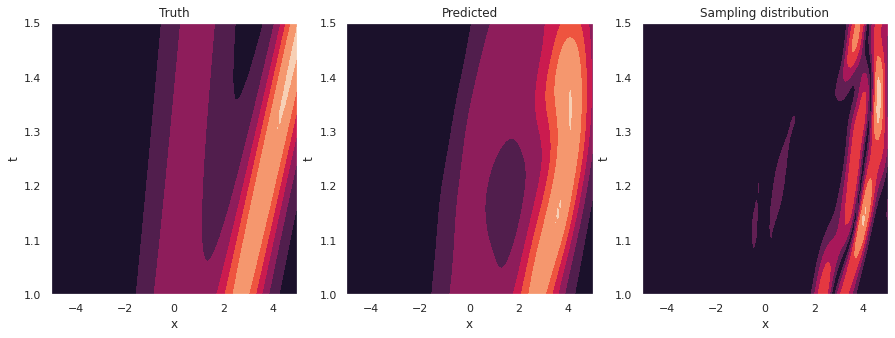

In [322]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.contourf(x_grid, t_grid, y_predict.cpu().detach().numpy().reshape(x_grid.shape))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Truth')

plt.subplot(132)
plt.contourf(x_grid, t_grid, p_predicted)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted')

plt.subplot(133)
plt.contourf(x_grid, t_grid, sample_dist)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sampling distribution')

plt.show()

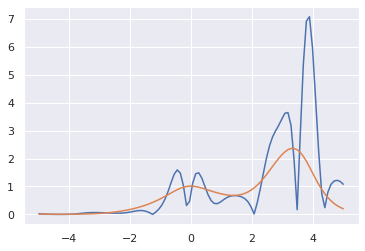

In [323]:
frame = 10
plt.plot(x, sample_dist[:, frame] * 100, label='Sample dist')
plt.plot(x, p_predicted[:, frame], label='Prediction')